### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choices

### Functions

In [2]:
class LOB():

    def __init__(self, initial_cancel_rates, initial_k, initial_a, initial_market_buy_order_rate, initial_market_sell_order_rate):

        self.time = 0
        self.mid_prices = []

        self.total_order_rates = []
        self.total_cancel_rates = []
        self.total_bid_limit_rates = []
        self.total_ask_limit_rates = []
        self.total_market_buy_rates = []
        self.total_market_sell_rates = []

        self.order_size = 100
        self.tick_size = 1
        self.num_ticks = 100
        self.max_i = 50

        self.price_grid = [0 for i in range(self.num_ticks)]
        self.ask_idx = round(self.num_ticks/2)
        self.bid_idx = self.ask_idx - 1

        self.limit_rates = self.initialize_limit_rates(initial_k, initial_a, self.max_i)

        self.cancel_rates = self.initialize_cancel_rates(initial_cancel_rates)
        self.market_buy_order_rate = initial_market_buy_order_rate
        self.market_sell_order_rate = initial_market_sell_order_rate
        self.total_order_rate = self.calc_total_order_rate()

    def initialize_limit_rates(self, k, a, max_i):
        _limit_rates = [(i, k/((i+1)**a)) for i in range(0, max_i)]
        return _limit_rates

    def initialize_cancel_rates(self, rates):
        extension = [rates[4] for i in range(self.max_i - 5)]
        rates.extend(extension)
        return rates

    def update_mid_price(self):
        # ask = self.price_grid[self.ask_idx]
        # bid = self.price_grid[self.bid_idx]
        mid_price = (self.bid_idx - self.ask_idx) / 2

        self.mid_prices.append(mid_price)
            
    def step(self):

        # Add next order
        self.new_order()

        # Advance time
        self.time += self.time_until_next_order()

        # Update the mid price
        self.update_mid_price()

        # Update the total rate
        self.total_order_rate = self.calc_total_order_rate()


    def execute_order(self, type, i=0):

        # Market buying and selling
        if type == "MARKET-BUY":
            # print(f"execute_order() MARKET-BUY ask_idx = {self.ask_idx}")
            if self.price_grid[self.ask_idx] > 0 :
                self.price_grid[self.ask_idx] -= self.order_size
            else:
                # Force a buy price
                pass
        elif type == "MARKET-SELL":
            # print(f"execute_order() MARKET-SELL bid_idx = {self.bid_idx}")
            if self.price_grid[self.bid_idx] > 0:
                self.price_grid[self.bid_idx] -= self.order_size
            else:
                # Force a sell price
                pass

        # Limit buying and selling
        elif type == "LIMIT-BUY":
            order_idx = self.ask_idx - i - 1
            # print(f"execute_order() LIMIT-BUY order_idx = {order_idx}")
            self.price_grid[order_idx] += self.order_size
        elif type == "LIMIT-SELL":
            order_idx = self.bid_idx + i + 1
            # print(f"execute_order() LIMIT-SELL order_idx = {order_idx}")
            if order_idx < self.num_ticks:
                self.price_grid[order_idx] += self.order_size

        # Cancelling buy and sell orders
        elif type == "CANCEL-BUY":
            order_idx = self.ask_idx - i - 1
            # print(f"execute_order() CANCEL-BUY order_idx = {order_idx}")
            if self.price_grid[order_idx] >= self.order_size:
                self.price_grid[order_idx] -= self.order_size
        elif type == "CANCEL-SELL":
            order_idx = self.bid_idx + i + 1
            # print(f"execute_order() CANCEL-SELL order_idx = {order_idx}")
            if self.price_grid[order_idx] >= self.order_size:
                self.price_grid[order_idx] -= self.order_size


    def new_order(self):

        weights = []

        # These are the probs for either sell or buy, not both
        _market_buy_order_prob = self.market_buy_order_rate / self.total_order_rate
        _market_sell_order_prob = self.market_sell_order_rate / self.total_order_rate

        # Calculate the probability of a limit order at each position
        _limit_order_probs = [rate[1] / self.total_order_rate for rate in self.limit_rates]

        # Calculate the probability of cancelling the order for all asks
        ask_end_range = min((self.num_ticks - self.bid_idx - 1), self.max_i)
        _ask_cancel_order_totals = [self.cancel_rates[i] * (self.price_grid[self.max_i + i]/self.order_size)
             for i in range(0, ask_end_range)]
        _ask_cancel_order_probs = [(value / self.total_order_rate) for value in _ask_cancel_order_totals]

        # Calculate the probability of cancelling the order for all bids
        bid_end_range = min(self.ask_idx, self.max_i)
        _bid_cancel_order_totals = [self.cancel_rates[i] * (self.price_grid[self.max_i - i - 1]/self.order_size)
                              for i in range(0, bid_end_range)]
        _bid_cancel_order_probs = [(value / self.total_order_rate) for value in _bid_cancel_order_totals]

        # Add all probabilities to the list with weights
        weights.append(_market_buy_order_prob)
        weights.append(_market_sell_order_prob)
        weights.extend(_limit_order_probs)
        weights.extend(_bid_cancel_order_probs)
        weights.extend(_ask_cancel_order_probs)

        _bid_cancel_length = len(_bid_cancel_order_probs)

        # Choose an order to perform
        indexes = [i for i in range(0, len(weights))]
        weight_index = choices(indexes, weights)[0]

        if weight_index == 0:
            # Market buy
            self.execute_order(type="MARKET-BUY")
        elif weight_index == 1:
            # Market sell
            self.execute_order(type="MARKET-SELL")

        elif weight_index > 1 and weight_index < self.max_i + 2 :
            i = weight_index - 2
            if np.random.rand() < 0.5:
                # Limit buy order at i = order_index
                self.execute_order(type="LIMIT-BUY", i=i)
            else:
                # Limit sell order at i = order_index
                self.execute_order(type="LIMIT-SELL", i=i)

        elif weight_index >= self.max_i + 2 and weight_index < self.max_i + _bid_cancel_length + 2:
            i = round(weight_index - self.max_i) - 2
            # Cancel buy order at i = order_index - self.max_i
            self.execute_order(type="CANCEL-BUY", i=i)
        else:
            i = round(weight_index - self.max_i - _bid_cancel_length) - 2
            # Cancel buy order at i = order_index - self.max_i - _bid_cancel_length
            self.execute_order(type="CANCEL-SELL", i=i)
         

    def calc_total_order_rate(self):

        ask_end_range = min((self.num_ticks - self.bid_idx - 1), self.max_i)
        ask_limit_sum = sum([self.limit_rates[i][1] for i in range(0, ask_end_range)])

        bid_end_range = min(self.ask_idx - 1, self.max_i)
        bid_limit_sum = sum([self.limit_rates[i][1] for i in range(0, bid_end_range)])

        ask_cancel_sum = sum([self.cancel_rates[i] * (self.price_grid[self.max_i + i]/self.order_size) \
        for i in range(0, ask_end_range)])

        bid_cancel_sum = sum([self.cancel_rates[i] * (self.price_grid[self.max_i - i - 1]/self.order_size)
                              for i in range(0, bid_end_range)])
        

        total_order_rate = self.market_buy_order_rate + self.market_sell_order_rate + ask_limit_sum + bid_limit_sum + ask_cancel_sum + bid_cancel_sum
        # print(f"Total order rate = {total_order_rate}")

        self.total_order_rates.append(total_order_rate)
        self.total_cancel_rates.append(ask_cancel_sum)
        self.total_bid_limit_rates.append(bid_limit_sum)
        self.total_ask_limit_rates.append(ask_limit_sum)
        self.total_market_buy_rates.append(self.market_buy_order_rate)
        self.total_market_sell_rates.append(self.market_sell_order_rate)

        return total_order_rate

    def time_until_next_order(self):
        p = np.random.rand()
        return - np.log(p) / self.total_order_rate



### Running the VET/USDT model

In [3]:
# initial_limit_rates = [5.6014, 4.4890, 1.2115, 0.6304, 0.5723, 0.4058, 0.2613, 0.2516, 0.3744, 0.2432]
# initial_cancel_rates = [0.2461, 0.1313, 0.0313, 0.0188, 0.0130, 0.0124, 0.0099, 0.0135, 0.0178, 0.0164]
# inital_k = 6.8587
# initial_a = 1.515
# initial_market_buy_order_rate = 0.7953
# initial_market_sell_order_rate = 0.7953

initial_cancel_rates = [0.5909573063193575,
                        0.2847843787018583,
                        0.3635937256912535,
                        0.0853736392592706,
                        0.08441497858772075,]
initial_cancel_rates = [v/10 for v in initial_cancel_rates]

inital_k = 1.79
initial_a = 1.11
initial_market_buy_order_rate = 2.04
initial_market_sell_order_rate = 2.04

max_time = 1000
VET_price_grids = []

for i in range(10):

    print(i)

    model = LOB(initial_cancel_rates,
                inital_k, initial_a, initial_market_buy_order_rate, initial_market_sell_order_rate)

    while model.time < max_time:
    
        # print(f"bid idx = {model.bid_idx}, ask idx = {model.ask_idx}")
        model.step()

    _grid = np.array(model.price_grid)
    relative_price_grid = _grid / np.sum(_grid)
    VET_price_grids.append(relative_price_grid)



0
1
2
3
4
5
6
7
8
9


### Running the VTHO/USDT model

In [28]:
initial_cancel_rates = [2.0237952467558893,
                         1.2869677708763665,
                         1.5329745958255425,
                         1.6221759051060145,
                         0.7861725429905432, ]
initial_cancel_rates = [v/10 for v in initial_cancel_rates]

inital_k = 2.52
initial_a = 0.58
initial_market_buy_order_rate = 0.62
initial_market_sell_order_rate = 0.62

max_time = 1000
VTHO_price_grids = []

for i in range(100):

    print(i)

    model = LOB(initial_cancel_rates,
                inital_k, initial_a, initial_market_buy_order_rate, initial_market_sell_order_rate)

    while model.time < max_time:

        # print(f"bid idx = {model.bid_idx}, ask idx = {model.ask_idx}")
        model.step()

    _grid = np.array(model.price_grid)
    relative_price_grid = _grid / np.sum(_grid)
    VTHO_price_grids.append(relative_price_grid)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [33]:
df = pd.DataFrame(VTHO_price_grids)
df.to_csv("Model/Code/src/LOB/LOB_VTHO.csv")

In [1]:
VTHO_price_grids[0]

NameError: name 'VTHO_price_grids' is not defined

### Plot the VET LOB

In [14]:
VET_price_grids = pd.read_csv("Model/Code/src/LOB/LOB_VET.csv")
VET_price_grids = [list(VET_price_grids.iloc[i,1:]) for i in range(100)]
VET_price_grids[-1]

[0.0,
 0.0020833333333333,
 0.0,
 0.0,
 0.00625,
 0.0,
 0.0041666666666666,
 0.0041666666666666,
 0.00625,
 0.00625,
 0.0020833333333333,
 0.0020833333333333,
 0.0,
 0.0020833333333333,
 0.00625,
 0.0041666666666666,
 0.0020833333333333,
 0.0041666666666666,
 0.0104166666666666,
 0.0041666666666666,
 0.00625,
 0.0041666666666666,
 0.0125,
 0.0041666666666666,
 0.0083333333333333,
 0.0125,
 0.0104166666666666,
 0.00625,
 0.0041666666666666,
 0.00625,
 0.0104166666666666,
 0.0104166666666666,
 0.0020833333333333,
 0.0125,
 0.0208333333333333,
 0.0145833333333333,
 0.0104166666666666,
 0.0166666666666666,
 0.0104166666666666,
 0.0229166666666666,
 0.01875,
 0.01875,
 0.0166666666666666,
 0.025,
 0.0354166666666666,
 0.0291666666666666,
 0.0416666666666666,
 0.0166666666666666,
 0.0479166666666666,
 0.0,
 0.0020833333333333,
 0.025,
 0.01875,
 0.025,
 0.03125,
 0.0291666666666666,
 0.0291666666666666,
 0.0333333333333333,
 0.0208333333333333,
 0.0125,
 0.0104166666666666,
 0.02083333333333

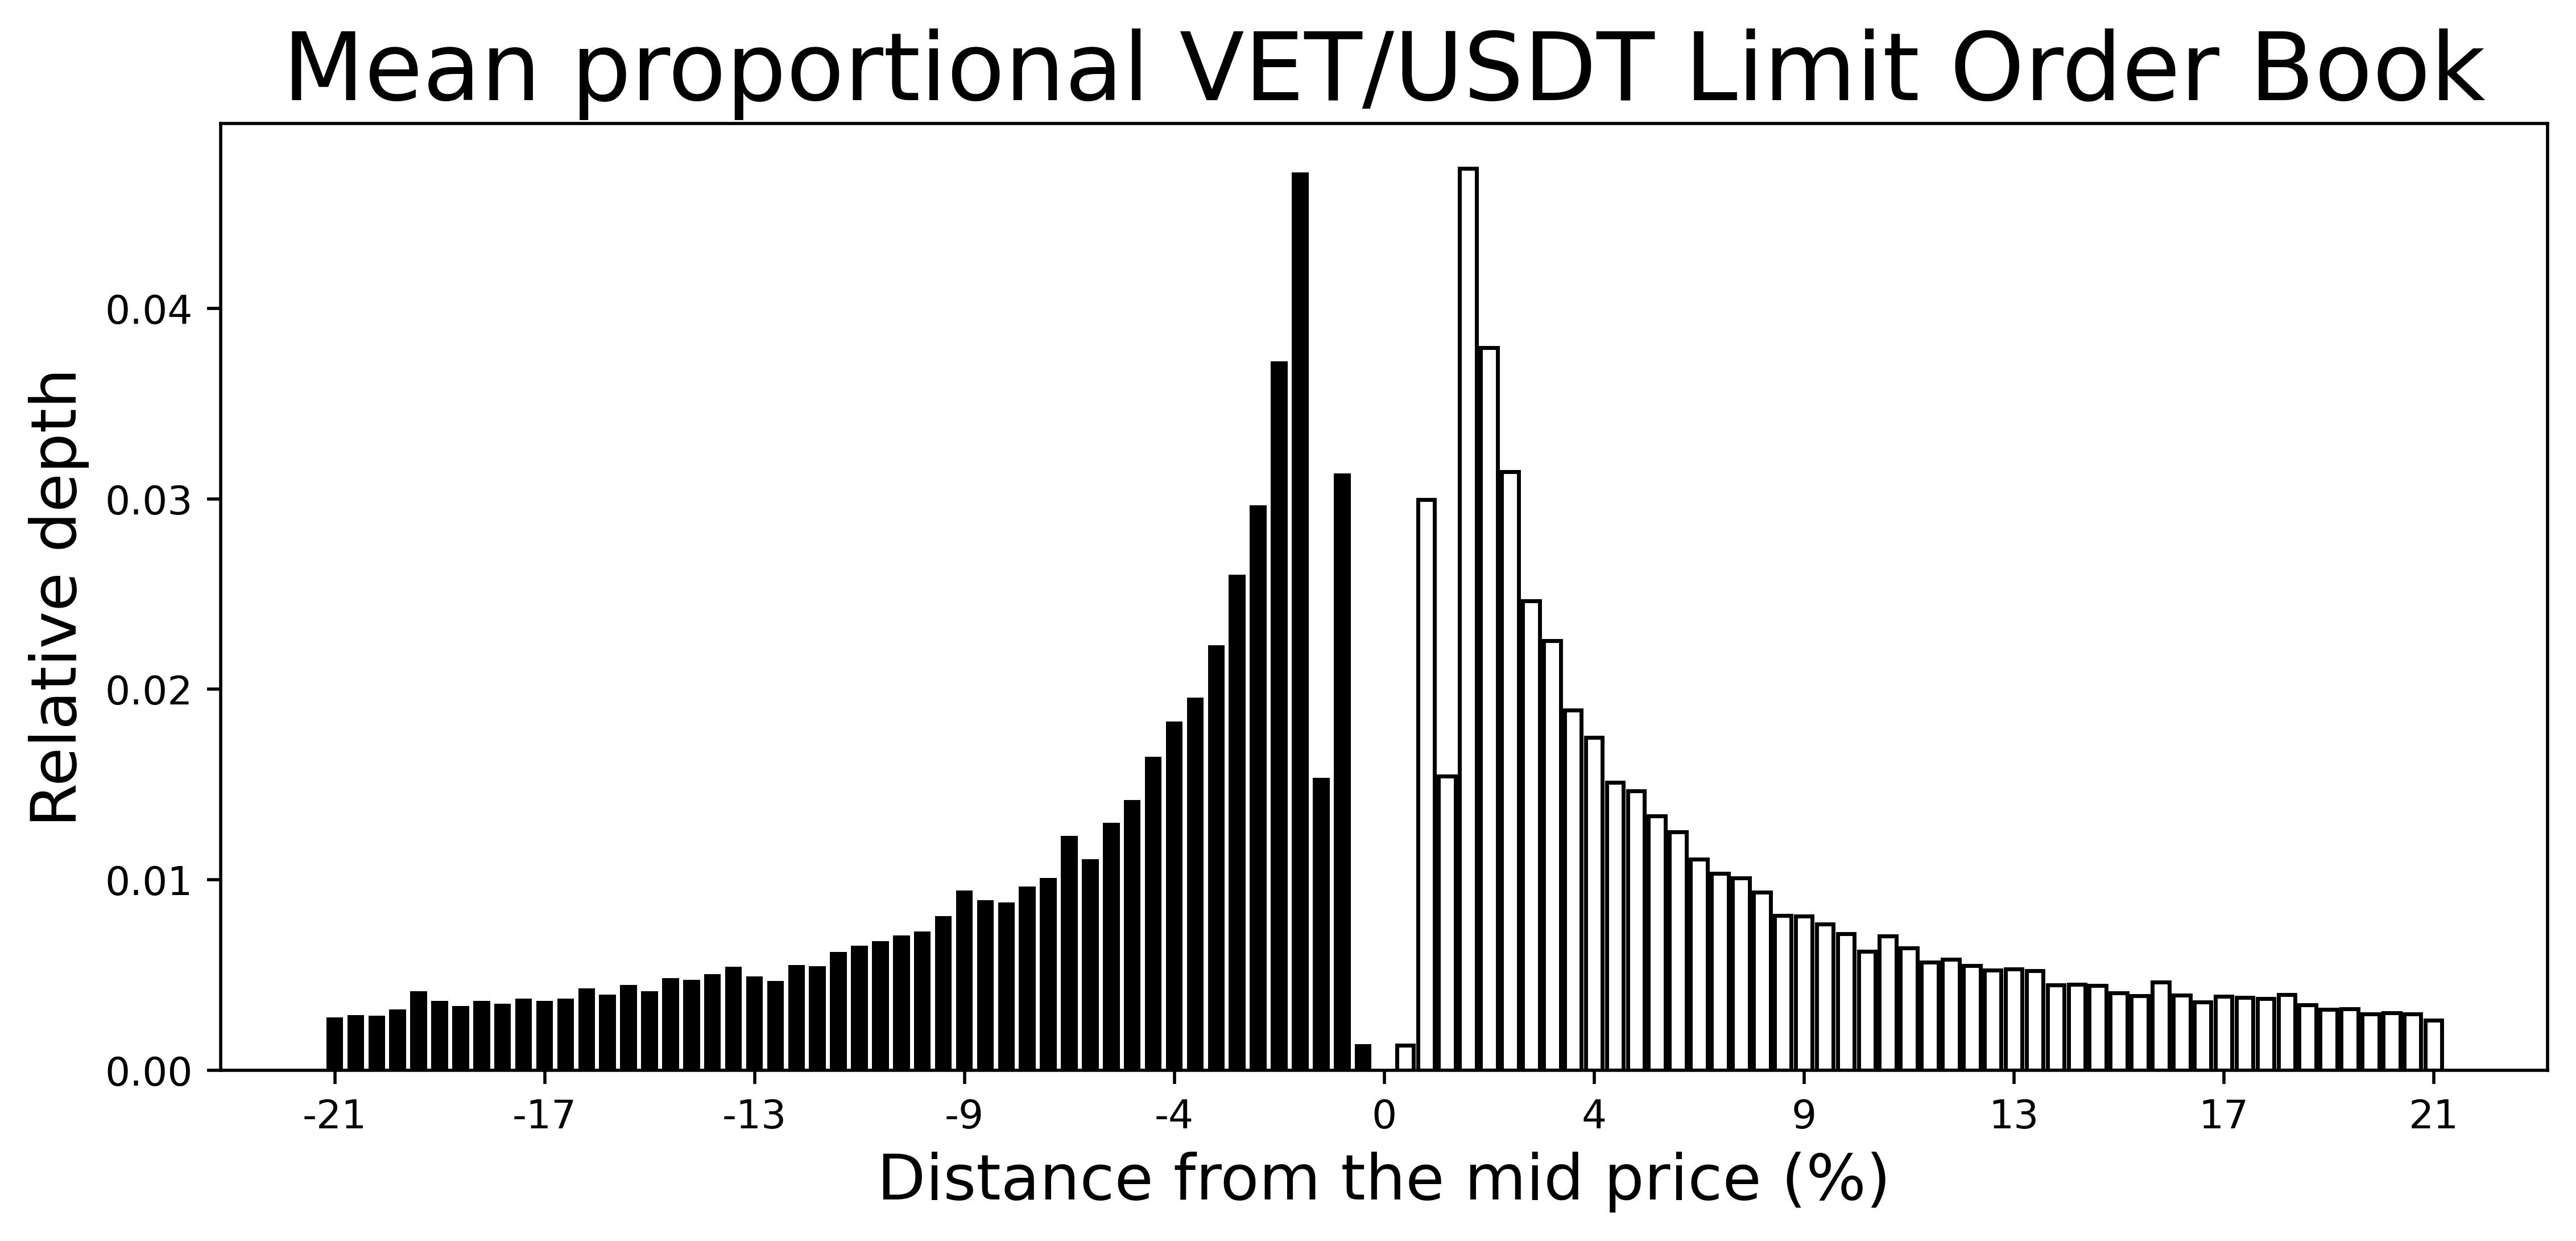

In [6]:
VET_price_grids = pd.read_csv("Model/Code/src/LOB/LOB_VET.csv")
VET_price_grids = [list(VET_price_grids.iloc[i,1:]) for i in range(100)]

arr = np.array([grid for grid in VET_price_grids])
arr = np.mean(arr, axis=0)
relative_price_grid = arr

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=500)
plt.tight_layout(pad=5.0)
plt.title("Mean proportional VET/USDT Limit Order Book", fontsize=24)

ax.bar([i for i in range(50)], relative_price_grid[:50], fill=True, color="black")
ax.bar([i for i in range(51, 101)],
       relative_price_grid[50:], fill=False,)

_labels = [round(i*0.426) for i in range(-50, 51, 10)]
plt.xticks([i for i in range(0, 101, 10)], labels=_labels)


ax.set_ylabel('Relative depth', fontsize=16)
ax.set_xlabel('Distance from the mid price (%)', fontsize=16)
ax.tick_params(axis='y')

# print(f"bid idx = {model.bid_idx}, ask idx = {model.ask_idx}")


### Plot the VTHO LOB

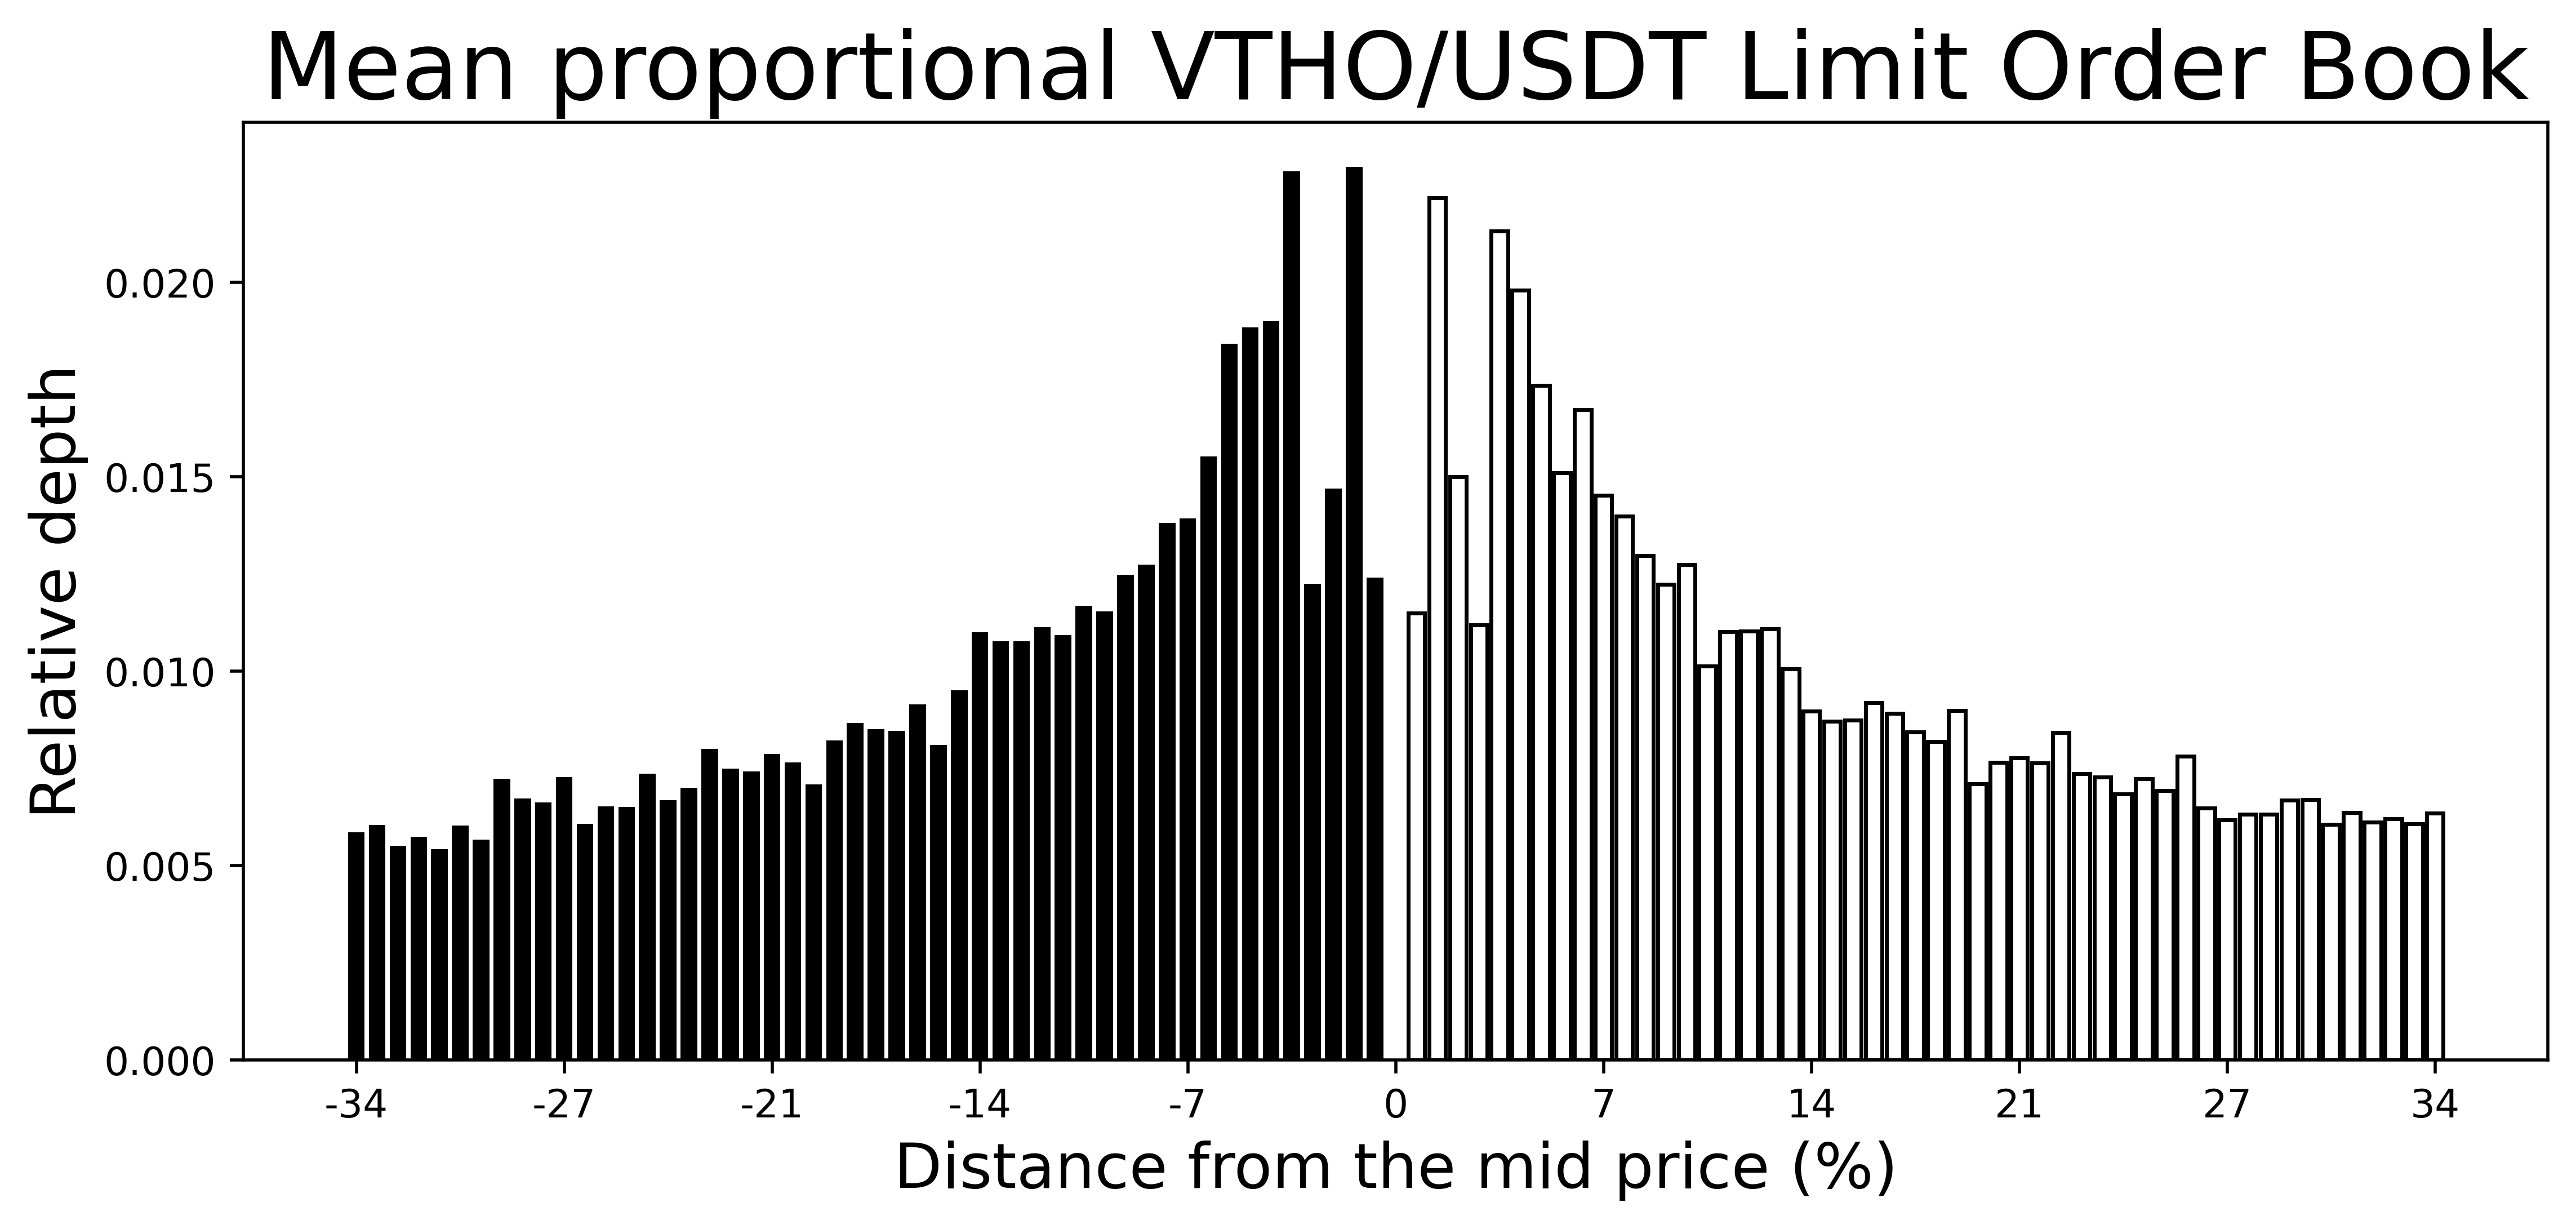

In [30]:
VTHO_price_grids = pd.read_csv("Model/Code/src/LOB/LOB_VTHO.csv")
VTHO_price_grids = [list(VTHO_price_grids.iloc[i, 1:]) for i in range(100)]

arr = np.array([grid for grid in VTHO_price_grids])
arr = np.mean(arr, axis=0)
relative_price_grid = arr

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=500)
plt.tight_layout(pad=5.0)
plt.title("Mean proportional VTHO/USDT Limit Order Book", fontsize=24)

ax.bar([i for i in range(50)], relative_price_grid[:50], fill=True, color="black")
ax.bar([i for i in range(51, 101)],
       relative_price_grid[50:], fill=False,)

_labels = [round(i*0.684) for i in range(-50, 51, 10)]
plt.xticks([i for i in range(0, 101, 10)], labels=_labels)

ax.set_ylabel('Relative depth', fontsize=16)
ax.set_xlabel('Distance from the mid price (%)', fontsize=16)
ax.tick_params(axis='y')

# print(f"bid idx = {model.bid_idx}, ask idx = {model.ask_idx}")


### Liquidities

In [4]:
VET_price_grids = pd.read_csv("Model/Code/src/LOB/LOB_VET.csv")
VET_price_grids = [list(VET_price_grids.iloc[i, 1:]) for i in range(100)]
arr = np.array([grid for grid in VET_price_grids])
arr = np.mean(arr, axis=0)

_LOB_bids = arr[:50][::-1]
_LOB_asks = arr[50:]


_LOB_bids.cumsum()
# VET_2pct = arr.cumsum().searchsorted(0.02)


array([0.00136498, 0.03271512, 0.0480578 , 0.0952188 , 0.13244707,
       0.16211723, 0.18814516, 0.21046843, 0.23003759, 0.24834926,
       0.26480425, 0.27898597, 0.29198965, 0.30307198, 0.31538477,
       0.32546485, 0.33512178, 0.3439149 , 0.35284824, 0.36227209,
       0.37034656, 0.37762847, 0.38469685, 0.39147897, 0.39800952,
       0.40420709, 0.40966595, 0.41517728, 0.4198726 , 0.42478047,
       0.43021866, 0.43524512, 0.43998522, 0.44482022, 0.44896342,
       0.45343405, 0.45739009, 0.46168844, 0.46544921, 0.46909477,
       0.47285873, 0.47635761, 0.47998577, 0.48335895, 0.48698174,
       0.4911266 , 0.49430563, 0.49717701, 0.50007406, 0.50282803])

In [5]:
VTHO_price_grids = pd.read_csv("Model/Code/src/LOB/LOB_VTHO.csv")
VTHO_price_grids = [list(VTHO_price_grids.iloc[i, 1:]) for i in range(100)]
arr = np.array([grid for grid in VTHO_price_grids])
arr = np.mean(arr, axis=0)

_LOB_bids = arr[:50][::-1]
_LOB_asks = arr[50:]


_LOB_bids.cumsum()
# VET_2pct = arr.cumsum().searchsorted(0.02)


array([0.01241257, 0.0353857 , 0.05008917, 0.06233852, 0.08519682,
       0.10420514, 0.12305818, 0.14147787, 0.15699962, 0.1709359 ,
       0.18474562, 0.19749102, 0.20997102, 0.22150871, 0.23318528,
       0.24410857, 0.25524093, 0.26600736, 0.27678044, 0.28777819,
       0.29728387, 0.305381  , 0.31452538, 0.32299036, 0.33149501,
       0.34016211, 0.3483744 , 0.35545713, 0.36311488, 0.37099001,
       0.37840935, 0.38589514, 0.39389465, 0.40088978, 0.40756612,
       0.41492652, 0.42143629, 0.42795299, 0.43402024, 0.44129723,
       0.44792184, 0.45463892, 0.46186437, 0.46752556, 0.47355701,
       0.47897686, 0.48471066, 0.49020905, 0.49624717, 0.50210231])

### Example order book

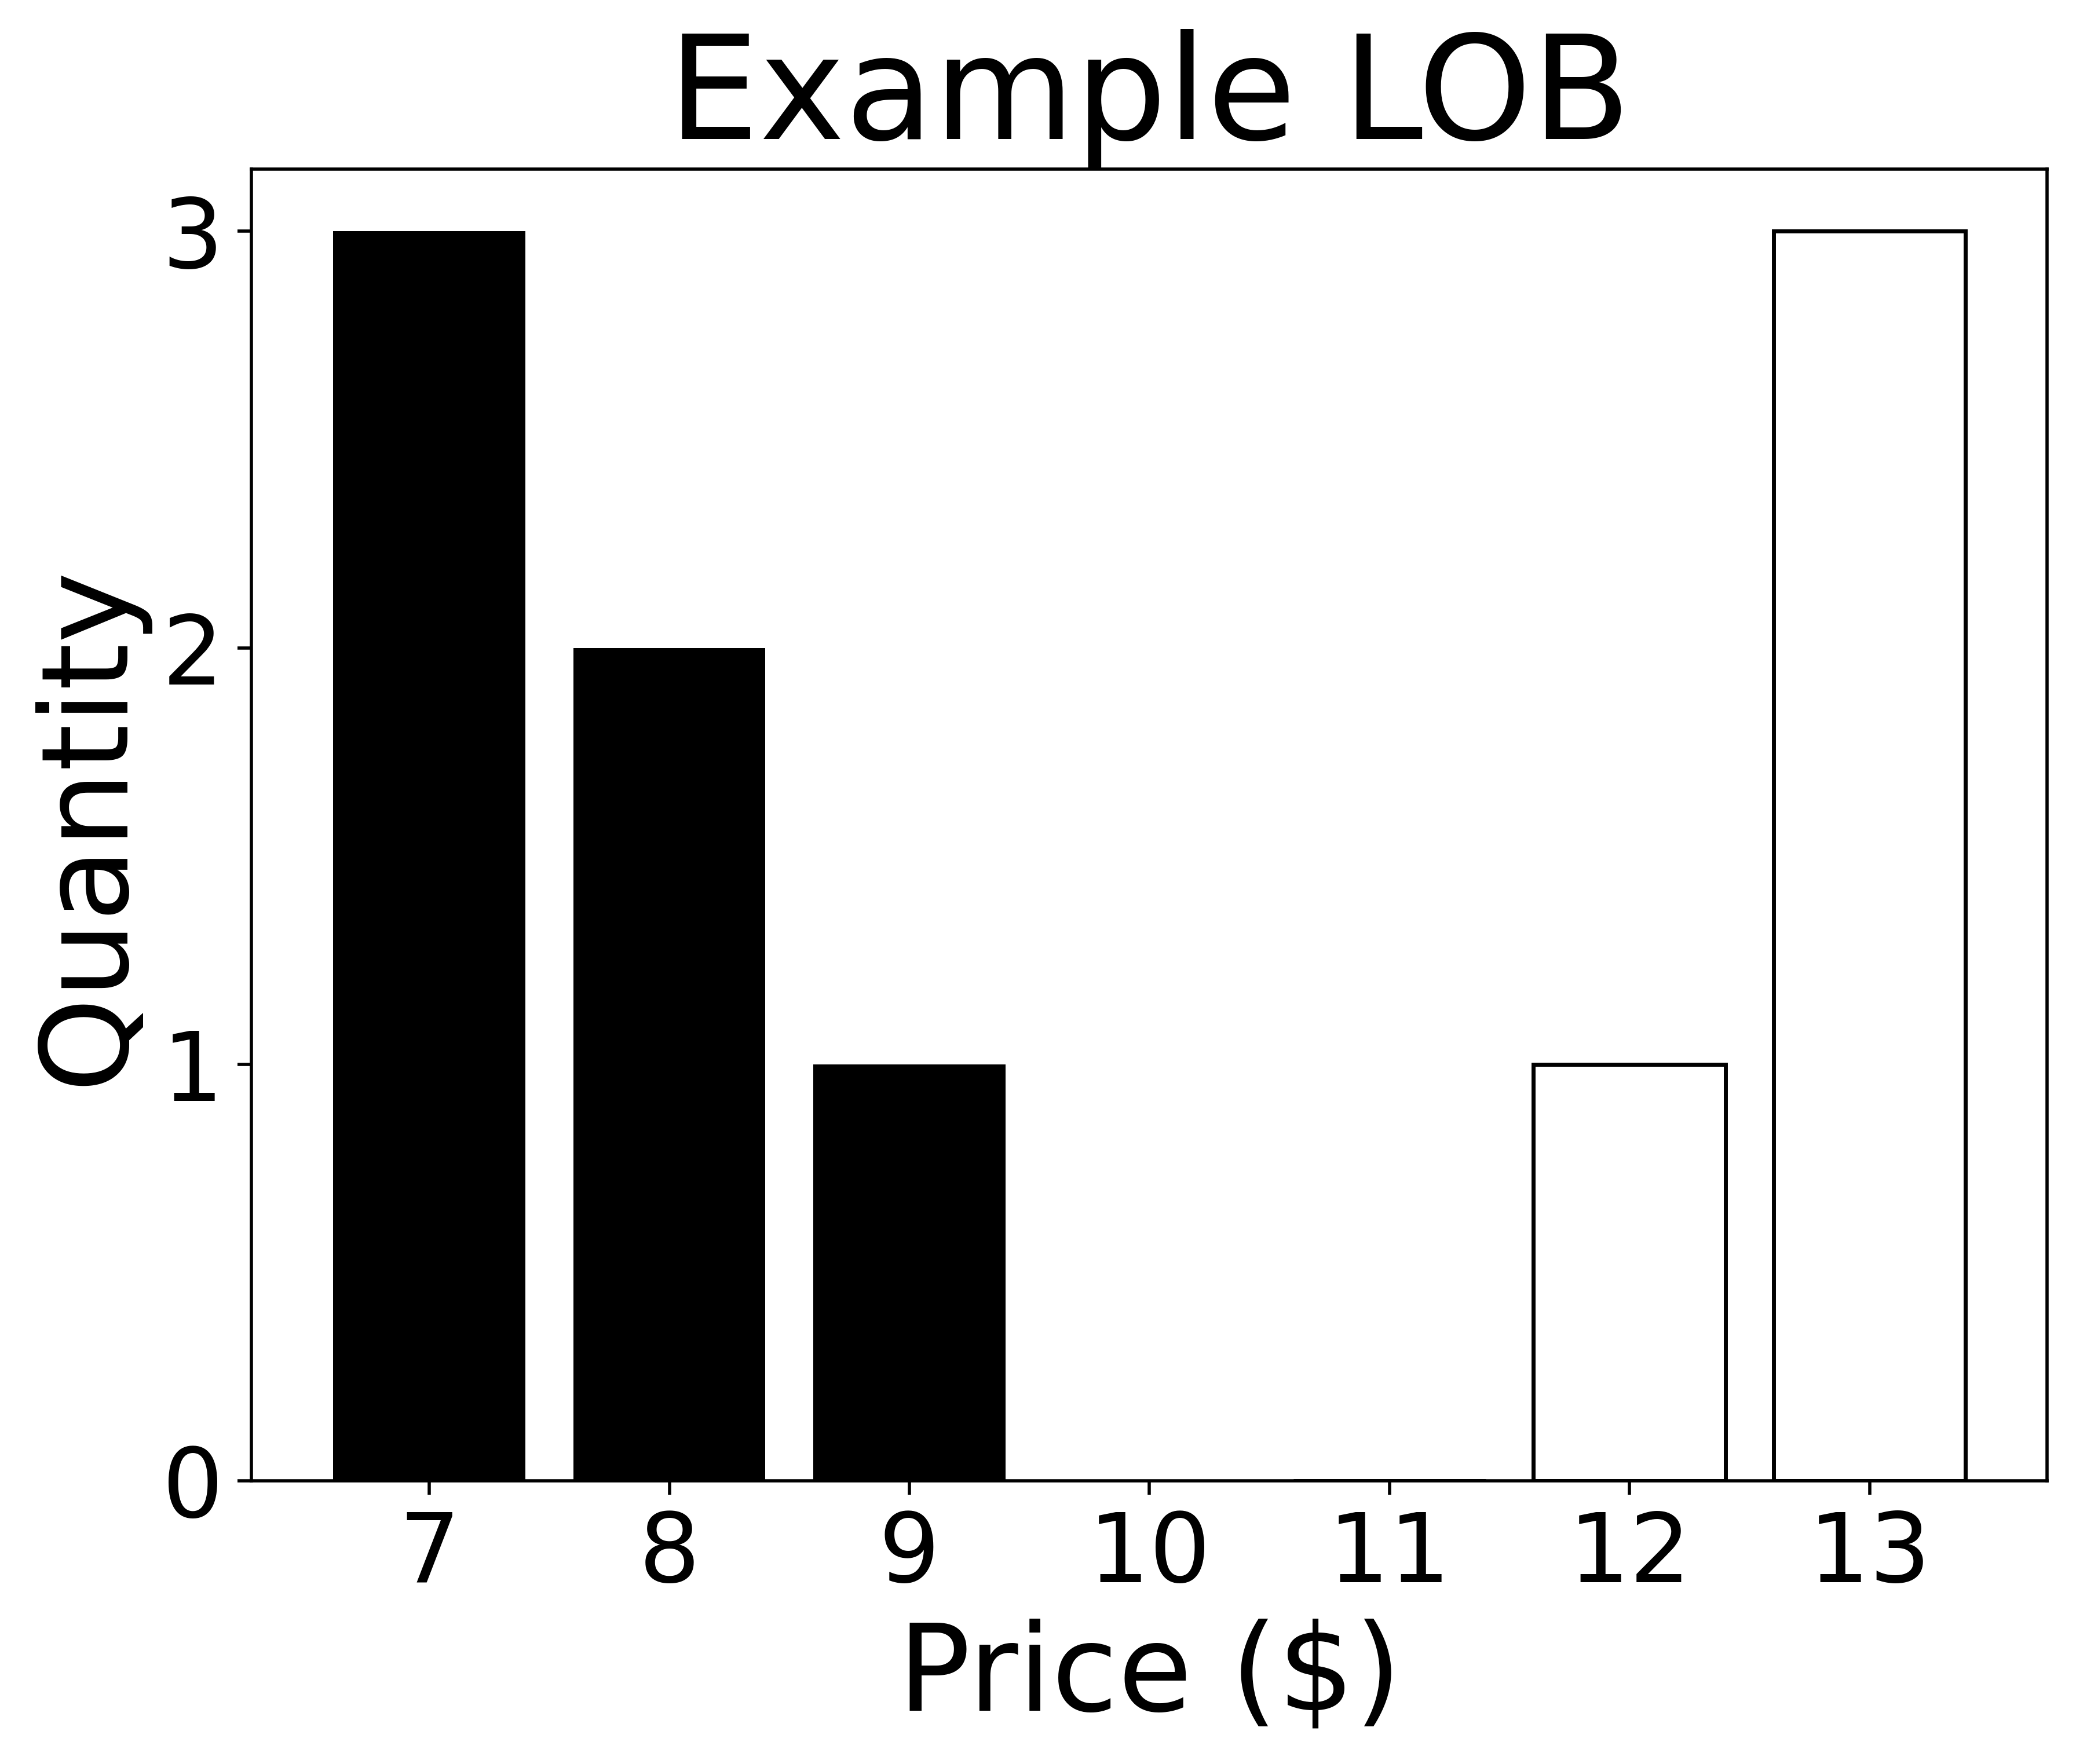

In [9]:

relative_price_grid = [3,2,1,0,1,3]

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=500)
# plt.tight_layout(pad=2.0)
plt.title("Example LOB", fontsize=36)

plot1 = ax.bar([i for i in range(3)], relative_price_grid[:3], fill=True, color="black", label="Bids")
plot2 = ax.bar([i for i in range(4, 7)],
       relative_price_grid[3:], fill=False, label="Asks")

_labels = [round(i) for i in range(7, 14, 1)]
plt.xticks([i for i in range(0, 7, 1)], labels=_labels, fontsize=24)
plt.yticks([i for i in range(0, 4, 1)], fontsize=24)

ax.set_ylabel('Quantity', fontsize=30)
ax.set_xlabel('Price ($)', fontsize=30)
# ax.tick_params(axis='y')

# Add legend
lns = plot1 + plot2
labels = [l.get_label() for l in lns]
# plt.legend(lns, labels, loc=0)
